In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_rows=100

In [3]:
products = pd.read_csv('products.csv')
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [4]:
del products['product_name_lenght'], products['product_description_lenght'], products['product_photos_qty']
products

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,700.0,31.0,13.0,20.0


In [5]:
products['product_volume_cm3'] = products.product_length_cm*products.product_height_cm*products.product_width_cm
products

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0,4420.0
...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,12300.0,40.0,40.0,40.0,64000.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,1700.0,16.0,19.0,16.0,4864.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,1400.0,27.0,7.0,27.0,5103.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,700.0,31.0,13.0,20.0,8060.0


In [6]:
#количество уникальных продуктов
products.product_id.nunique()

32951

In [7]:
products.isna().sum()

product_id                 0
product_category_name    610
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
product_volume_cm3         2
dtype: int64

Проверим, стоит ли товары с отсутствующей категорией (Other) разбивать еще на несколько категорий, сравнив среднее и среднеквадратическое отклонение в этой категории с данными характеристиками других категорий

In [8]:
products.groupby(['product_category_name']).agg({'product_volume_cm3':'mean'}).sort_values(by='product_volume_cm3')

,product_volume_cm3
product_category_name,
dvds_blu_ray,1746.854167
telefonia,1865.841270
livros_importados,1935.387097
livros_tecnicos,2758.991870
relogios_presentes,3470.398044
livros_interesse_geral,3900.046296
fashion_bolsas_e_acessorios,4480.634865
fashion_underwear_e_moda_praia,4584.132075
audio,4970.172414


In [9]:
products.groupby(['product_category_name']).agg({'product_volume_cm3':'std'}).sort_values(by='product_volume_cm3')

,product_volume_cm3
product_category_name,
livros_importados,1206.736803
pc_gamer,1620.278165
telefonia,2023.848886
dvds_blu_ray,2896.124152
livros_tecnicos,3084.661858
livros_interesse_geral,3503.460753
fashion_roupa_infanto_juvenil,3800.294752
relogios_presentes,4020.254201
flores,4789.929803


In [10]:
products.fillna({'product_category_name':'Other'}, inplace=True)

In [11]:
order_items = pd.read_csv('order_items.csv', parse_dates=[4])
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [12]:
order_items.product_id.nunique()

32951

In [13]:
orders = pd.read_csv('orders.csv', parse_dates=['order_approved_at'])
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [14]:
full_data = pd.merge(order_items, orders.loc[:, ['order_id', 'order_approved_at']], on='order_id', how='left')
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13
...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32


In [15]:
full_data = pd.merge(full_data, products, on='product_id', how='left')
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35,cool_stuff,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13,pet_shop,30000.0,50.0,30.0,40.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18,perfumaria,200.0,16.0,10.0,15.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25,esporte_lazer,967.0,21.0,24.0,19.0,9576.0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0


In [17]:
full_data.product_category_name.nunique()

74

Объеденим в единую категорию Электронику и товары для детей, остальные данные отбросим

In [18]:
el = ['informatica_acessorios', \
'eletroportateis', \
'eletronicos', \
'consoles_games', \
'eletrodomesticos_2', \
'eletrodomesticos', \
'audio', \
'portateis_casa_forno_e_cafe', \
'sinalizacao_e_seguranca', \
'construcao_ferramentas_ferramentas', \
'tablets_impressao_imagem', \
'dvds_blu_ray', \
'pc_gamer']

In [19]:
child = ['brinquedos', \
'bebes', \
'fraldas_higiene', \
'fashion_roupa_infanto_juvenil']

In [20]:
cat = el+child

In [21]:
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35,cool_stuff,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13,pet_shop,30000.0,50.0,30.0,40.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18,perfumaria,200.0,16.0,10.0,15.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25,esporte_lazer,967.0,21.0,24.0,19.0,9576.0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0


In [24]:
import datetime as dt

In [29]:
full_data['Index'] = range(len(full_data))

In [30]:
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,Index
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35,cool_stuff,650.0,28.0,9.0,14.0,3528.0,0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13,pet_shop,30000.0,50.0,30.0,40.0,60000.0,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0,2
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18,perfumaria,200.0,16.0,10.0,15.0,2400.0,3
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0,112645
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0,112646
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25,esporte_lazer,967.0,21.0,24.0,19.0,9576.0,112647
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0,112648


Посчитаем количество продаж конкретных товаров

In [43]:
product_sells = full_data.groupby(['product_id']).agg({'Index':'count'}).sort_values(by='Index')
product_sells

,Index
product_id,
00066f42aeeb9f3007548bb9d3f33c38,1
911e26785862f450cf2240fc5168f83d,1
911cfb37438b7fa9ad54535990178868,1
911b8d269dbaa6c005b23d04e1c7fcbc,1
9117307cf75efa6e964d697f0d1297f9,1
...,...
368c6c730842d78016ad823897a372db,388
389d119b48cf3043d311335e499d9c6b,392
422879e10f46682990de24d770e7f83d,484


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BE3F9B12E0>]],
      dtype=object)

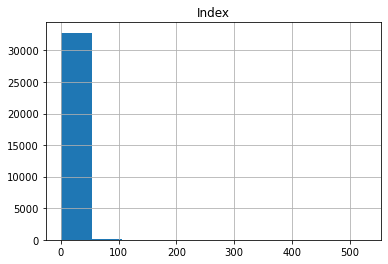

In [44]:
product_sells.hist()

Основная масса товаров продается меньше 50 раз

In [42]:
full_data[full_data.product_id == 'aca2eb7d00ea1a7b8ebd4e68314663af'].sort_values(by='order_approved_at')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,Index
11393,19f7b4b5c61de325dbfcf2547a700024,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2017-08-03 10:45:20,75.0,13.08,2017-07-27 10:45:20,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,11393
55353,7ddd225286ba5817d36116c8d2300407,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2017-08-04 14:33:04,75.0,20.02,2017-07-28 14:35:16,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,55353
40977,5d5128a0dbb59102263b66505895c98f,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2017-08-04 16:10:12,75.0,20.02,2017-07-28 16:10:12,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,40977
64256,92d132b6237a2bb7de6b7eac0f203773,2,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2017-08-08 11:25:16,75.0,13.08,2017-08-01 11:25:16,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,64256
64255,92d132b6237a2bb7de6b7eac0f203773,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2017-08-08 11:25:16,75.0,13.08,2017-08-01 11:25:16,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,64255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54659,7c38c132d8ee69d411b7a3eae6035211,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-07-17 02:35:14,89.9,32.65,2018-07-13 02:35:14,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,54659
41569,5eba6d8afdd49d9208232bbd26e9fd0f,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-07-25 09:19:12,89.9,26.93,2018-07-23 11:32:07,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,41569
98128,de9387b71120d212286385df34759406,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-08-08 15:45:09,89.9,17.76,2018-08-06 15:45:09,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,98128
65420,95811675a89b66659996da5285a021db,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-08-13 15:25:22,109.9,22.07,2018-08-09 15:25:22,moveis_decoracao,2600.0,50.0,10.0,30.0,15000.0,65420
